<font size="6"><center>**Model Building**</font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

running notebook configuration


In [3]:
import numpy as np
import pandas as pd


In [4]:
from src.data_api import sources, sinks
from src import utils, tags

from src import mle 

In [5]:
conf = utils.get_conf()

In [6]:
fparams = conf['func_params']

start_dt = fparams['start_dt']
end_dt = fparams['end_dt']
avol_top = float(fparams['avol_top'])
avol_window = int(fparams['avol_window'])
tau = int(fparams['target']['tau'])

val_dt = fparams['split_dt']['valid']
test_dt = fparams['split_dt']['test']

In [7]:
K_FOLDS = 3
RND_SEED = 123

# Load Data

In [8]:
feats_and_targets = sources.read_data(
    'feats_and_targets.csv', layer='interim',
    parse_dates=['date'], index_col=['date', 'ticker'])
feats_and_targets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 374331 entries, (Timestamp('2015-01-02 00:00:00'), 'A') to (Timestamp('2017-12-29 00:00:00'), 'ZTS')
Columns: 27 entries, sector to split_3f
dtypes: bool(1), float64(23), object(3)
memory usage: 76.1+ MB


In [9]:
pd.concat([feats_and_targets.head(2), feats_and_targets.tail(2)], axis=0)

,,sector,SP500,y_fwd_logrets_5d,x_intrad_upshadow,x_intrad_loshadow,x_returns_5d,x_zscore_5d,x_zscore_vol_5d,x_macd_5d_vs_20d,x_rsi,x_zscore_20d,x_zscore_vol_20d,x_zscore_60d,x_zscore_vol_60d,x_bb_60d,x_macd_50d_vs_252d,x_returns_1y,x_rets5d_vol_60d,x_rets5d_vol_120d,x_mkt_dispersion,x_wday_cos,x_wday_sin,x_is_eoq,x_mkt_volat_60d,x_mkt_volat_120d,split,split_3f
date,ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,A,Capital Goods,-0.0147,0.0007,0.1264,0.1847,-0.0115,-1.4744,0.9398,0.2672,55.3864,-0.1928,-0.5010,0.1058,-0.8054,0.0000,0.4378,0.1129,0.0405,0.0336,0.0543,0.3090,-0.9511,False,0.0236,0.0192,1.dev,1.train
2015-01-05,A,Capital Goods,-0.0341,0.0078,0.1361,0.0972,-0.0365,-1.5635,1.5077,0.0948,55.6667,-0.8393,-0.0693,-0.3988,-0.4243,0.0000,0.4540,0.1001,0.0406,0.0338,0.0628,1.0000,0.0000,False,0.0241,0.0194,1.dev,1.train
2017-12-28,ZTS,Health Care,0.0011,0.0133,0.1100,0.2500,-0.0044,0.5586,-1.2001,0.2580,59.9842,0.6349,-1.4923,1.0820,-1.6623,0.0000,8.6920,0.3552,0.0237,0.0218,0.0547,-0.8090,-0.5878,False,0.0057,0.0068,2.test,3.test
2017-12-29,ZTS,Health Care,-0.0036,0.0301,0.2100,0.0000,-0.0033,-0.9547,1.3702,0.2225,65.2919,0.0366,-0.0578,0.9494,-0.5330,0.0000,8.7416,0.3557,0.0238,0.0218,0.0637,0.3090,-0.9511,False,0.0056,0.0068,2.test,3.test


In [10]:
feats_and_targets.columns

Index(['sector', 'SP500', 'y_fwd_logrets_5d', 'x_intrad_upshadow',
       'x_intrad_loshadow', 'x_returns_5d', 'x_zscore_5d', 'x_zscore_vol_5d',
       'x_macd_5d_vs_20d', 'x_rsi', 'x_zscore_20d', 'x_zscore_vol_20d',
       'x_zscore_60d', 'x_zscore_vol_60d', 'x_bb_60d', 'x_macd_50d_vs_252d',
       'x_returns_1y', 'x_rets5d_vol_60d', 'x_rets5d_vol_120d',
       'x_mkt_dispersion', 'x_wday_cos', 'x_wday_sin', 'x_is_eoq',
       'x_mkt_volat_60d', 'x_mkt_volat_120d', 'split', 'split_3f'],
      dtype='object')

# Data Preparation

In [11]:
features = feats_and_targets.filter(regex='x_').columns
label = 'y_fwd_logrets_5d'

In [12]:
features

Index(['x_intrad_upshadow', 'x_intrad_loshadow', 'x_returns_5d', 'x_zscore_5d',
       'x_zscore_vol_5d', 'x_macd_5d_vs_20d', 'x_rsi', 'x_zscore_20d',
       'x_zscore_vol_20d', 'x_zscore_60d', 'x_zscore_vol_60d', 'x_bb_60d',
       'x_macd_50d_vs_252d', 'x_returns_1y', 'x_rets5d_vol_60d',
       'x_rets5d_vol_120d', 'x_mkt_dispersion', 'x_wday_cos', 'x_wday_sin',
       'x_is_eoq', 'x_mkt_volat_60d', 'x_mkt_volat_120d'],
      dtype='object')

In [13]:
feats_and_targets = feats_and_targets.replace({np.inf: np.nan, -np.inf: np.nan}).fillna(0.)

# Splitting

In [15]:
df_dev = feats_and_targets.query('split == "1.dev"')
X_dev = df_dev[features]
y_dev = df_dev[label]

df_test = feats_and_targets.query('split == "2.test"')
X_test =  df_test[features]
y_test =  df_test[label]

## Cross Validation

In [16]:
cvts_2f = mle.GroupTimeSeriesSplit(n_splits=K_FOLDS)

groups_idx_2f = [x.year*10000 + x.month*100 + x.day for x in X_dev.index.get_level_values('date')]

# Model Building

## Linear

In [29]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

cv_splits_2f = cvts_2f.split(X=y_dev, groups=groups_idx_2f)
model = Lasso( # check default!
              random_state=RND_SEED)

grid_hparams = {
    'fit_intercept': [False, True],
    'alpha': [0.001, 0.0001], 
               }

mod_cv = GridSearchCV(model, grid_hparams, scoring=('neg_root_mean_squared_error', 'r2'), cv=cv_splits_2f, n_jobs=-1, refit='neg_root_mean_squared_error')
mod_cv.fit(X_dev, y_dev)

GridSearchCV(cv=<generator object GroupTimeSeriesSplit.split at 0x0000021C29194F20>,
             estimator=Lasso(random_state=123), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.0001],
                         'fit_intercept': [False, True]},
             refit='neg_root_mean_squared_error',
             scoring=('neg_root_mean_squared_error', 'r2'))

In [30]:
df_lasso_gscv = pd.DataFrame(mod_cv.cv_results_).sort_values(by='rank_test_neg_root_mean_squared_error')
df_lasso_gscv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,2.4024,0.7967,0.2691,0.0296,0.0010,False,"{'alpha': 0.001, 'fit_intercept': False}",-0.0941,-0.0669,-0.0782,-0.0797,0.0111,1,-0.0072,-0.0107,-0.0011,-0.0063,0.0040,1
1,2.7524,0.8418,0.2666,0.0375,0.0010,True,"{'alpha': 0.001, 'fit_intercept': True}",-0.0942,-0.0669,-0.0782,-0.0798,0.0112,2,-0.0109,-0.0114,-0.0012,-0.0078,0.0047,2
2,2.5049,0.7373,0.2494,0.0390,0.0001,False,"{'alpha': 0.0001, 'fit_intercept': False}",-0.0944,-0.0670,-0.0782,-0.0799,0.0113,3,-0.0142,-0.0126,-0.0023,-0.0097,0.0053,3
3,2.4776,0.5523,0.2053,0.0261,0.0001,True,"{'alpha': 0.0001, 'fit_intercept': True}",-0.0944,-0.0671,-0.0782,-0.0799,0.0112,4,-0.0151,-0.0162,-0.0025,-0.0113,0.0062,4


In [31]:
mod_lasso = mod_cv.best_estimator_
mod_lasso.coef_

array([ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.93854409e-05, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.51815844e-05,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00])

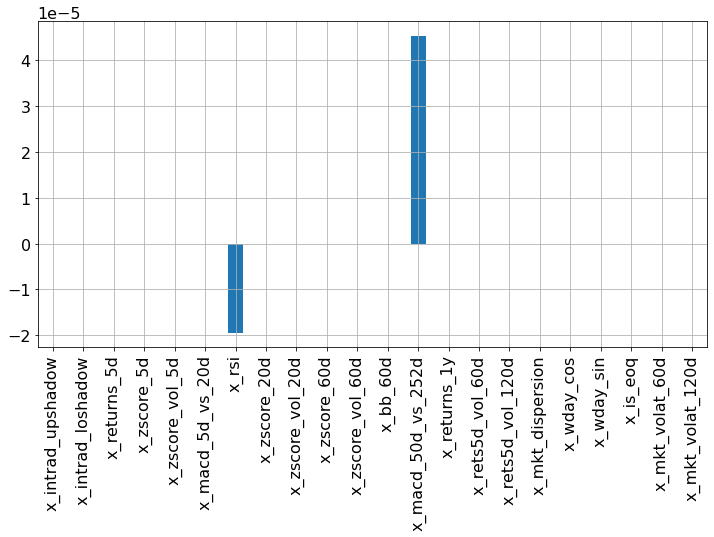

In [32]:
pd.Series(index=features, data=mod_lasso.coef_).plot.bar()
plt.grid()
plt.show()

In [33]:
mod_lasso.intercept_

0.0

In [34]:
p_dev = pd.Series(index= X_dev.index, data=mod_cv.predict(X_dev), name='y_pred')

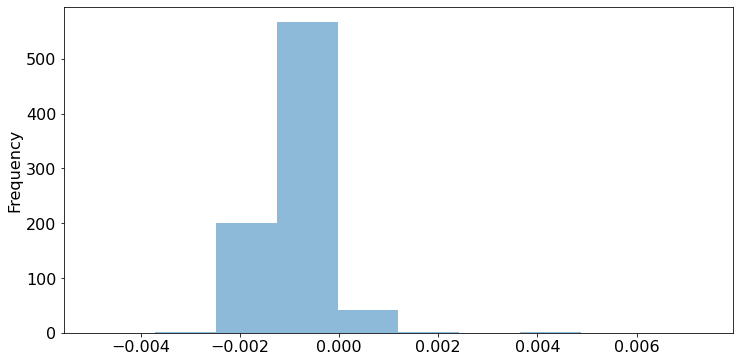

In [35]:
p_dev.plot.hist(label='y_pred',  alpha=0.5, density=True)
plt.show()